# DSO 522: Applied Time Series Analysis for Forecasting

## Week 10: ARIMA Models (part II)

### Fall 2024

#### Instructor: Dr. Matteo Sesia

<p align="center">
  <img src="img/marshall.png" alt="Marshall School of Business" width="600"/>
</p>

<link rel="stylesheet" type="text/css" href="custom.css">

# Interactive slides

These lecture slides are made using an interactive [Jupyter](https://jupyter.org/) notebook, powered by the [RISE](https://rise.readthedocs.io/en/latest/) extension.

In the lectures, we will run `R` code in Jupyter, using the `fpp3` package (which you should have already installed).

In [1]:
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

library(repr)
options(repr.matrix.max.rows=4)
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 250)

## Non-seasonal ARIMA models (review)

- One of the most widely applied approaches for time series forecasting, next to Exponential Smoothing.

- Exponential Smoothing focuses on describing trend and seasonality.

- ARIMA models focus on describing **autocorrelations**.

- ARIMA models utilize the following key concepts:
  - Differencing techniques (to make time series stationary)
  - AR(p) and MA(q) models (to describe stationary time series)

## AR(p) models

- In a multiple regression model, we forecast the variable of interest using a linear combination of predictors.

- In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable.

- The term autoregression indicates that it is a regression of the variable against itself.

Autoregressive model of order $p$: 
$$
y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t},
$$
where $\varepsilon_{t}$ is white noise.

## Stationary AR(p)

We normally restrict autoregressive models to stationary data, in which case some constraints on the values of the parameters are required.

- For AR(1): $-1 < \phi_1 < 1$
- For AR(2): $-1 < \phi_2 < 1$ and $\phi_1 + \phi_2 < 1$ and $\phi_2-\phi_1 < 1$

When $p \geq 3, the restrictions are much more complicated. 

The `fable` package takes care of these restrictions when estimating a model.

## MA(q) models

A moving average model of order $q$, namely MA(q), uses past forecast errors in a regression-like model, 
$$
y_{t} = c + \varepsilon_t + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \dots + \theta_{q}\varepsilon_{t-q},
$$
where $\varepsilon_t$  is white noise.

## Non-seasonal ARIMA models

Differencing + AR(p) + MA(q) $\Rightarrow$ *non-seasonal ARIMA model*.

ARIMA is an acronym for AutoRegressive Integrated Moving Average (in this context, “integration” is the reverse of differencing)

The full model can be written as 
\begin{equation}
  y'_{t} = c + \phi_{1}y'_{t-1} + \cdots + \phi_{p}y'_{t-p}
     + \theta_{1}\varepsilon_{t-1} + \cdots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t},
\end{equation}

where $y'_t$ is the differenced series (it may have been differenced more than once).

We call this an ARIMA(p,d,q) model, where
- $p$ = order of the autoregressive part;
- $d$ = degree of first differencing involved;
- $q$ = order of the moving average part.

## Backshift notation for ARIMA models

ARIMA(p,d,q):
\begin{equation}
  y'_{t} = c + \phi_{1}y'_{t-1} + \cdots + \phi_{p}y'_{t-p}
     + \theta_{1}\varepsilon_{t-1} + \cdots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}
\end{equation}
can be written as:
\begin{equation}
  \begin{array}{c c c c}
    (1-\phi_1B - \cdots - \phi_p B^p) & (1-B)^d y_{t} &= &c + (1 + \theta_1 B + \cdots + \theta_q B^q)\varepsilon_t\\
    {\uparrow} & {\uparrow} & &{\uparrow}\\
    \text{AR($p$)} & \text{$d$ differences} & & \text{MA($q$)}\\
  \end{array}
\end{equation}

## ARIMA modelling in `fable`

The `ARIMA()` function in the `fable` package uses a variation of the Hyndman-Khandakar algorithm (Hyndman & Khandakar, 2008). Default behavior:

1. The number of differences $0 \leq d \leq 2$ is determined using repeated KPSS tests. 
2. The values of $p$ and $q$ are then chosen by minimising the AICc after differencing the data d times. A stepwise search is used to avoid considering every possible combination of $p$ and $q$.

## Stepwise search over $p$ and $q$ (for fixed $d$)

a. Four initial models are fitted: ARIMA(0,d,0), ARIMA(2,d,2), ARIMA(1,d,0), ARIMA(0,d,1). 
   - A constant is included unless $d=2$. 
   - If $d \leq 1$, an additional model is fitted: ARIMA(0,d,0) without constant.
   
b. The best model (with the smallest AICc value) fitted in step (a) is set to be the “current model”. 

c. Variations on the current model are considered: 
   - vary $p$ and/or $q$ from the current model by $\pm 1$;
   - include/exclude $c$ from the current model.
   The best model considered so far becomes the new current model.
   
d. Repeat Step 2(c) until no lower AICc can be found.


## Hyndman-Khandakar algorithm (stepwise)

<p align="center">
  <img src="img/ARMAgridsearch-1.png" alt="ARIMA search algorithm" width="400"/>
</p>

Note: a more exaustive search can be done with `ARIMA(Exports, stepwise=FALSE)`.

## Before Hyndman-Khandakar algorithm

1. Plot the data and identify any unusual observations.

2. If necessary, transform the data (using a Box-Cox transformation) to stabilise the variance.

## Example: Central African Republic exports

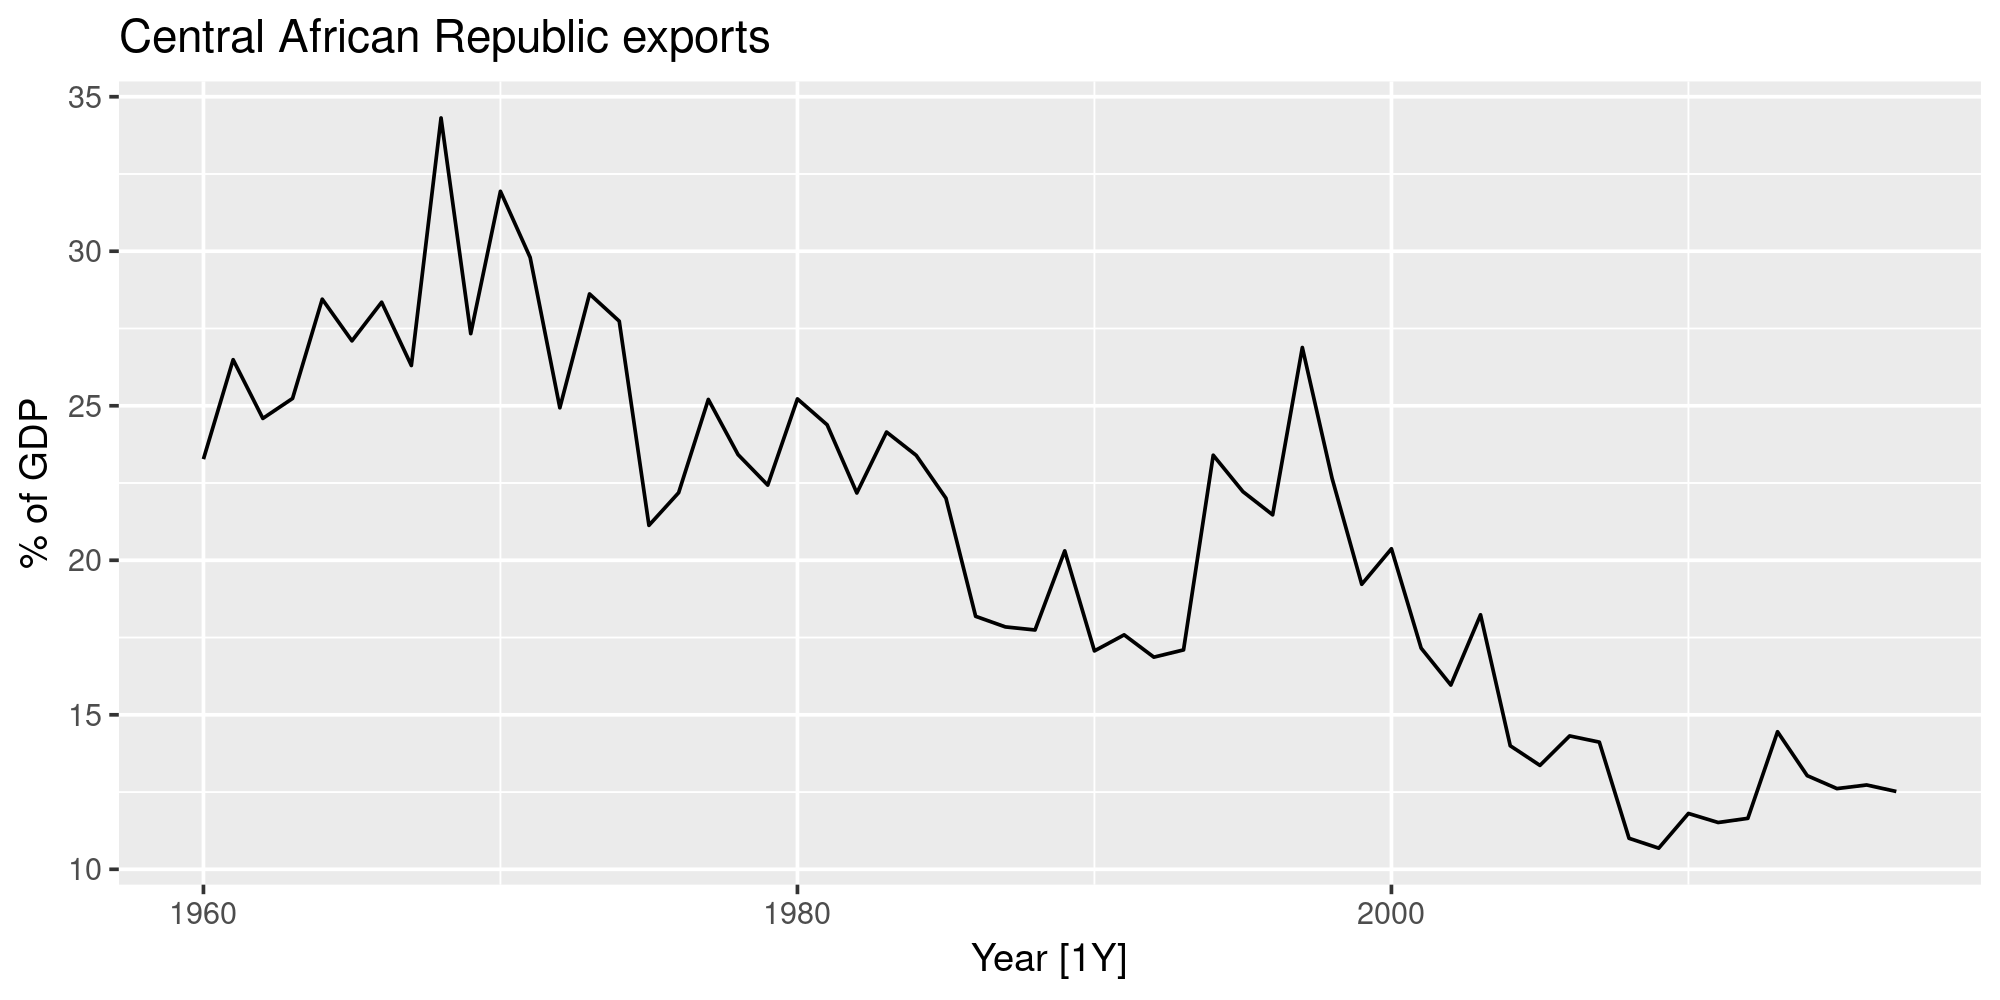

In [2]:
global_economy |>
  filter(Code == "CAF") |>
  autoplot(Exports) +
  labs(title="Central African Republic exports",
       y="% of GDP")

To address the non-stationarity, we will take a first difference of the data.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


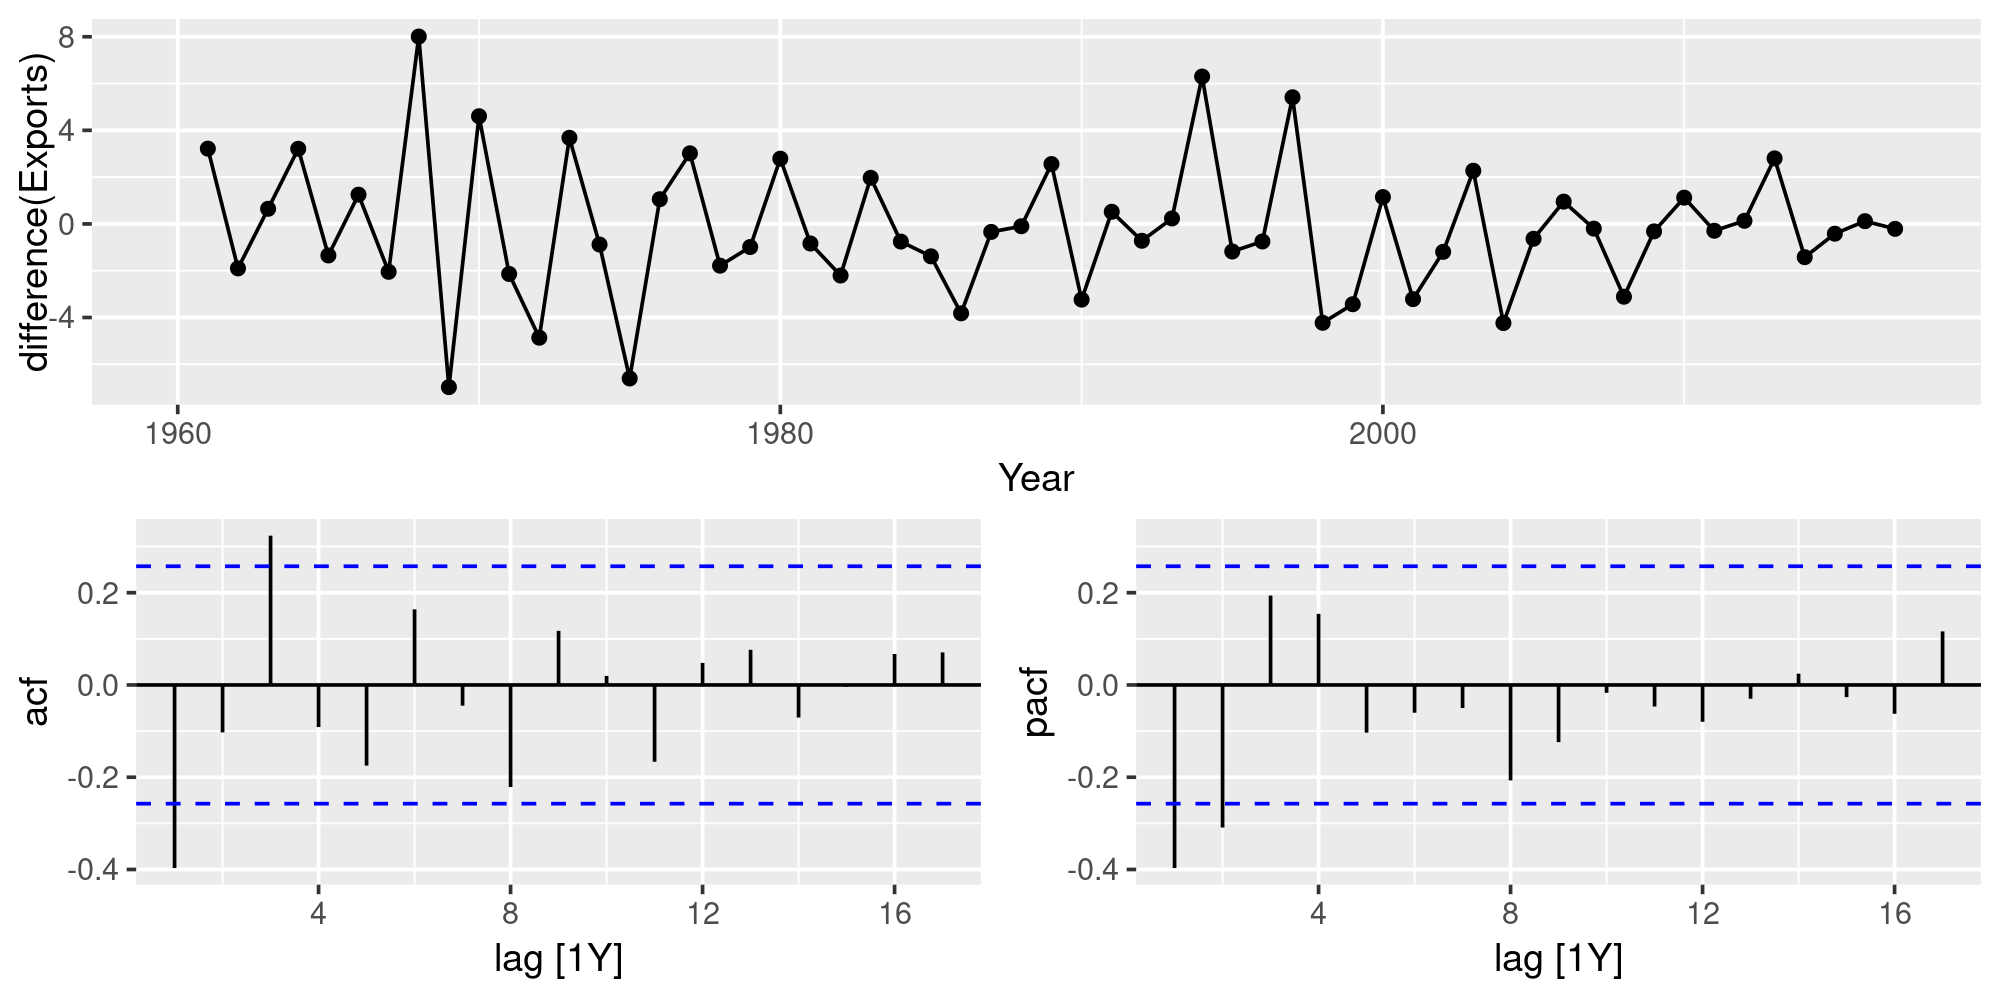

In [3]:
global_economy |>
  filter(Code == "CAF") |>
  gg_tsdisplay(difference(Exports), plot_type='partial')

## Using PACF to find $p$ or $q$ (rule of thumb)

The data may follow an ARIMA(p,d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

- the ACF is exponentially decaying or sinusoidal;

- there is a significant spike at lag $p$ in the PACF, but none beyond lag $p$.

The data may follow an ARIMA(0,d,q) model if the ACF and PACF plots of the differenced data show the following patterns:

- the PACF is exponentially decaying or sinusoidal;

- there is a significant spike at lag $q$ in the ACF, but none beyond lag $q$.

## Example: CAF exports

In [4]:
caf_fit <- global_economy |>
  filter(Code == "CAF") |>
  model(arima210 = ARIMA(Exports ~ pdq(2,1,0)),
        arima013 = ARIMA(Exports ~ pdq(0,1,3)),
        stepwise = ARIMA(Exports),
        search = ARIMA(Exports, stepwise=FALSE))

caf_fit |> pivot_longer(!Country, names_to = "Model name", values_to = "Orders")

#glance(caf_fit) |> arrange(AICc) |> select(.model:BIC)

Country,Model name,Orders
<fct>,<chr>,<model>
Central African Republic,arima210,"<ARIMA(2,1,0)>"
Central African Republic,arima013,"<ARIMA(0,1,3)>"
Central African Republic,stepwise,"<ARIMA(2,1,2)>"
Central African Republic,search,"<ARIMA(3,1,0)>"


## Residual analysis

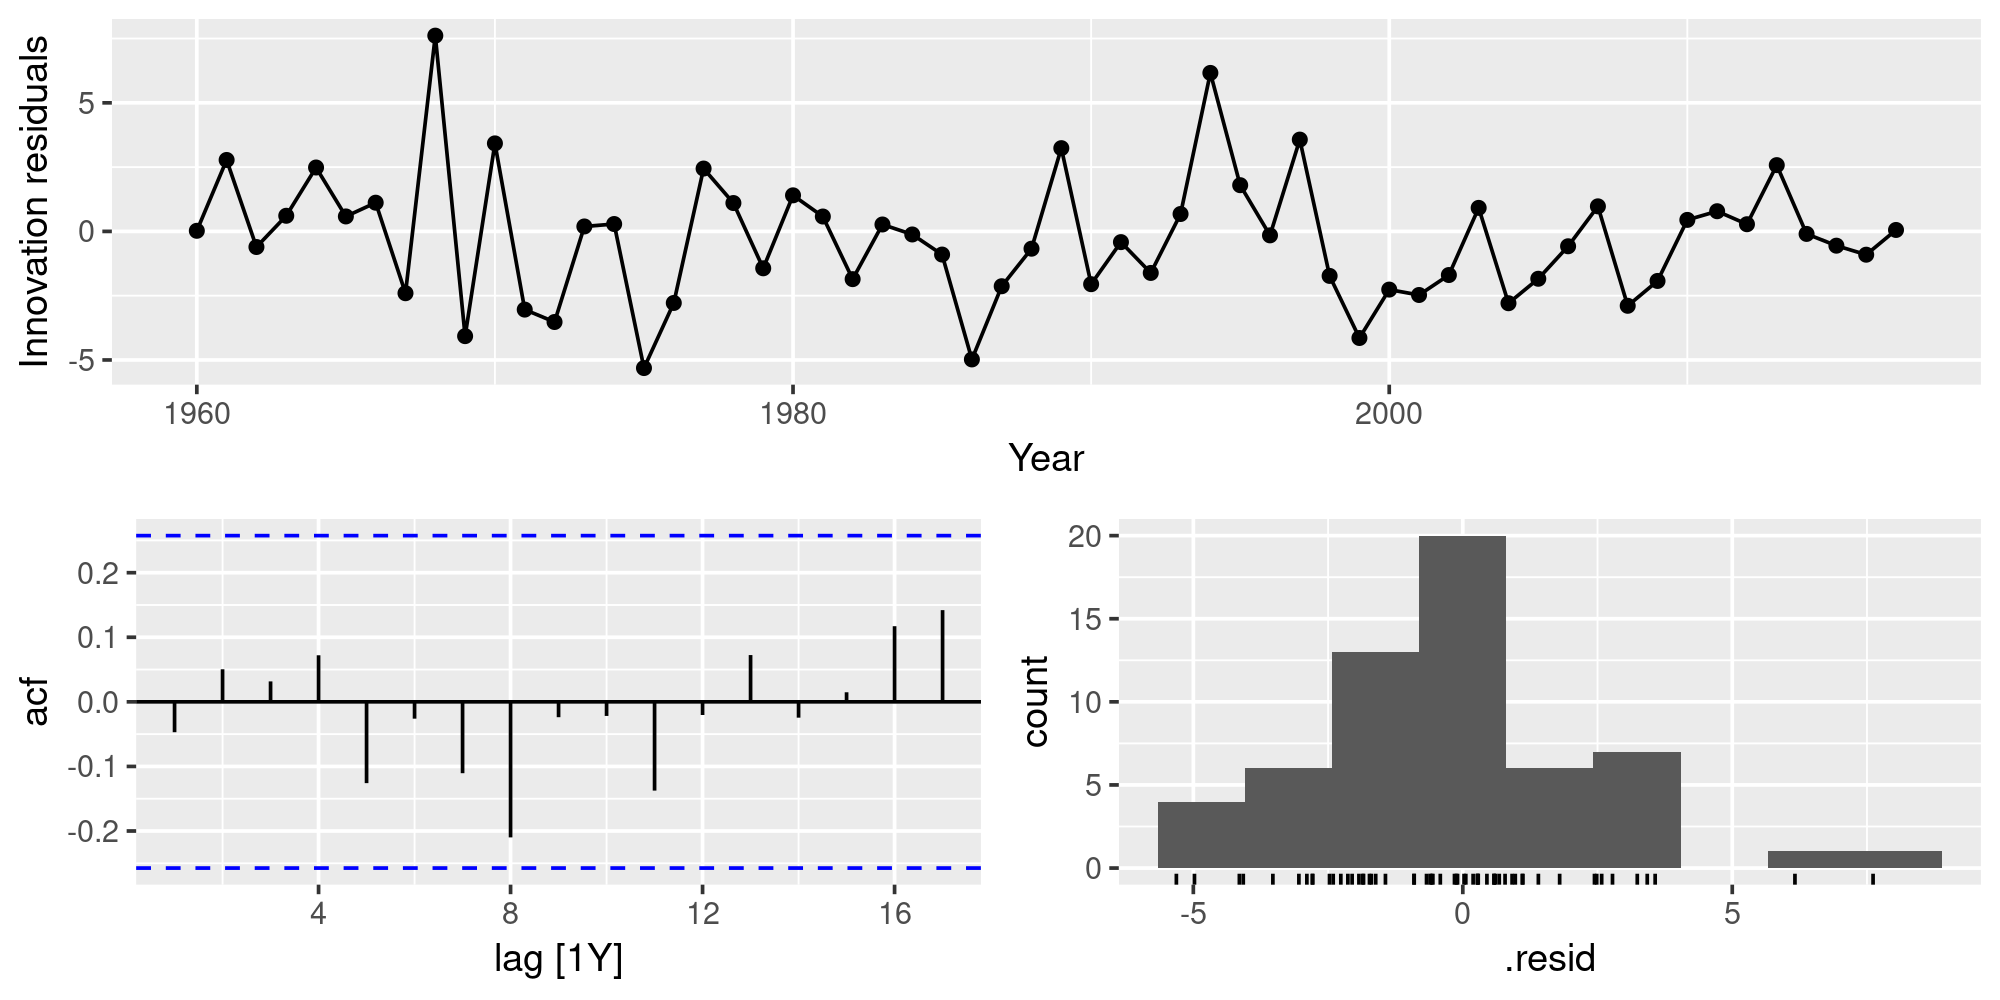

In [5]:
caf_fit |>
  select(search) |>
  gg_tsresiduals()

## Forecasts

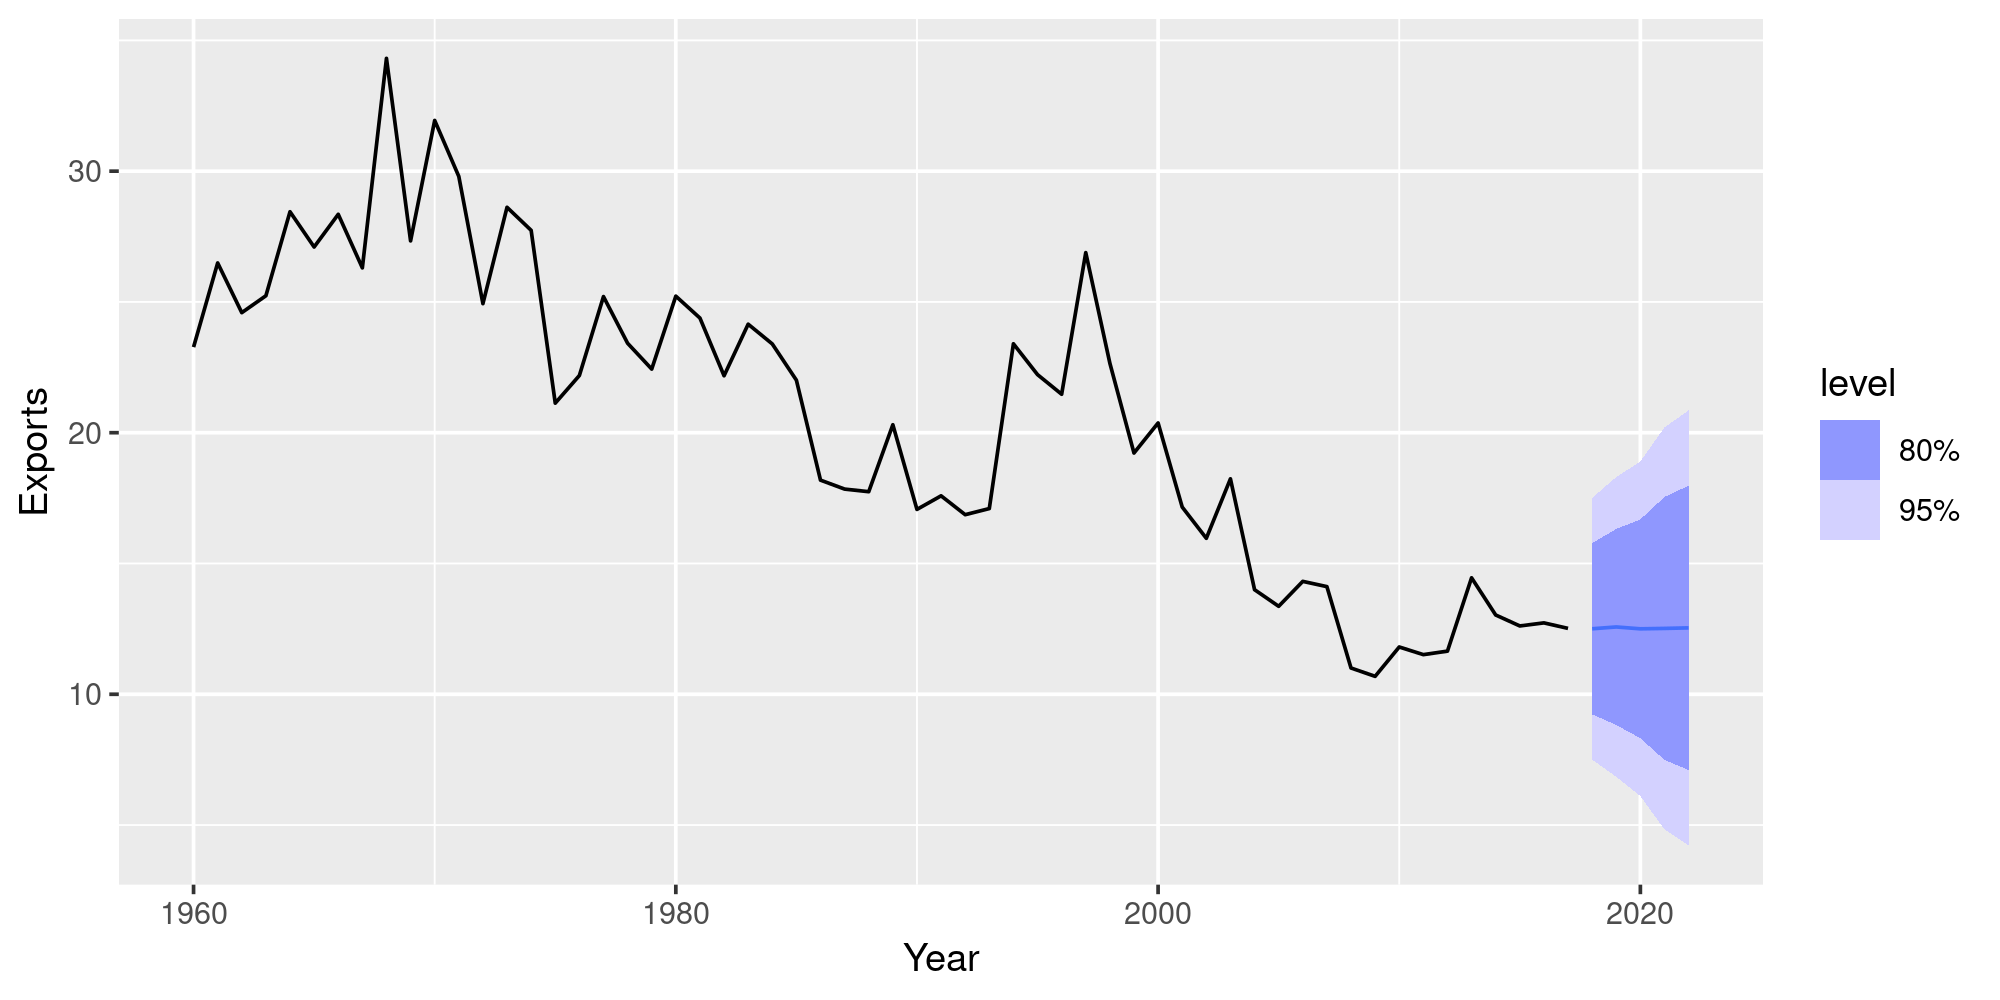

In [6]:
caf_fit |>
  forecast(h=5) |>
  filter(.model=='search') |>
  autoplot(global_economy)

## Comparison with RW model

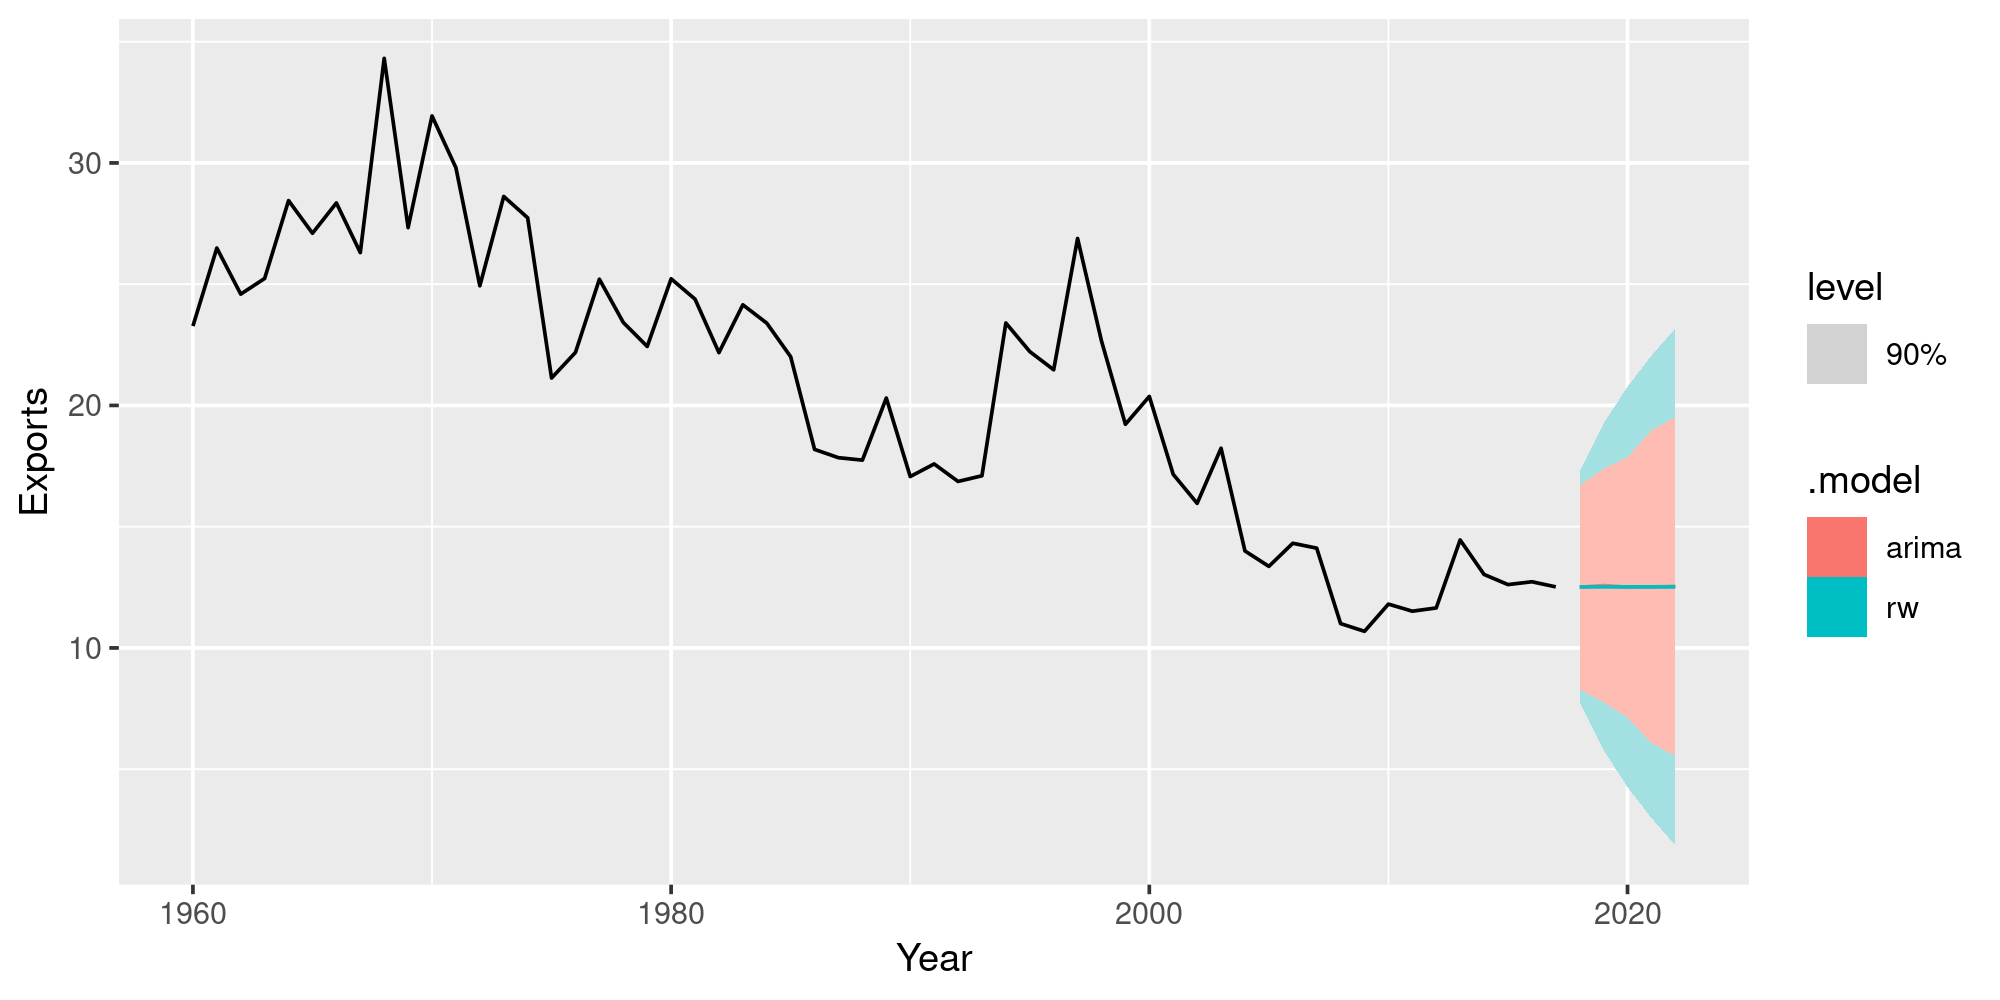

In [7]:
global_economy |>
  filter(Code == "CAF") |>
  model(arima = ARIMA(Exports, stepwise=FALSE),
        rw = RW(Exports)) |>
  forecast(h=5) |>
  autoplot(global_economy, level=90)

## Including a constant in ARIMA

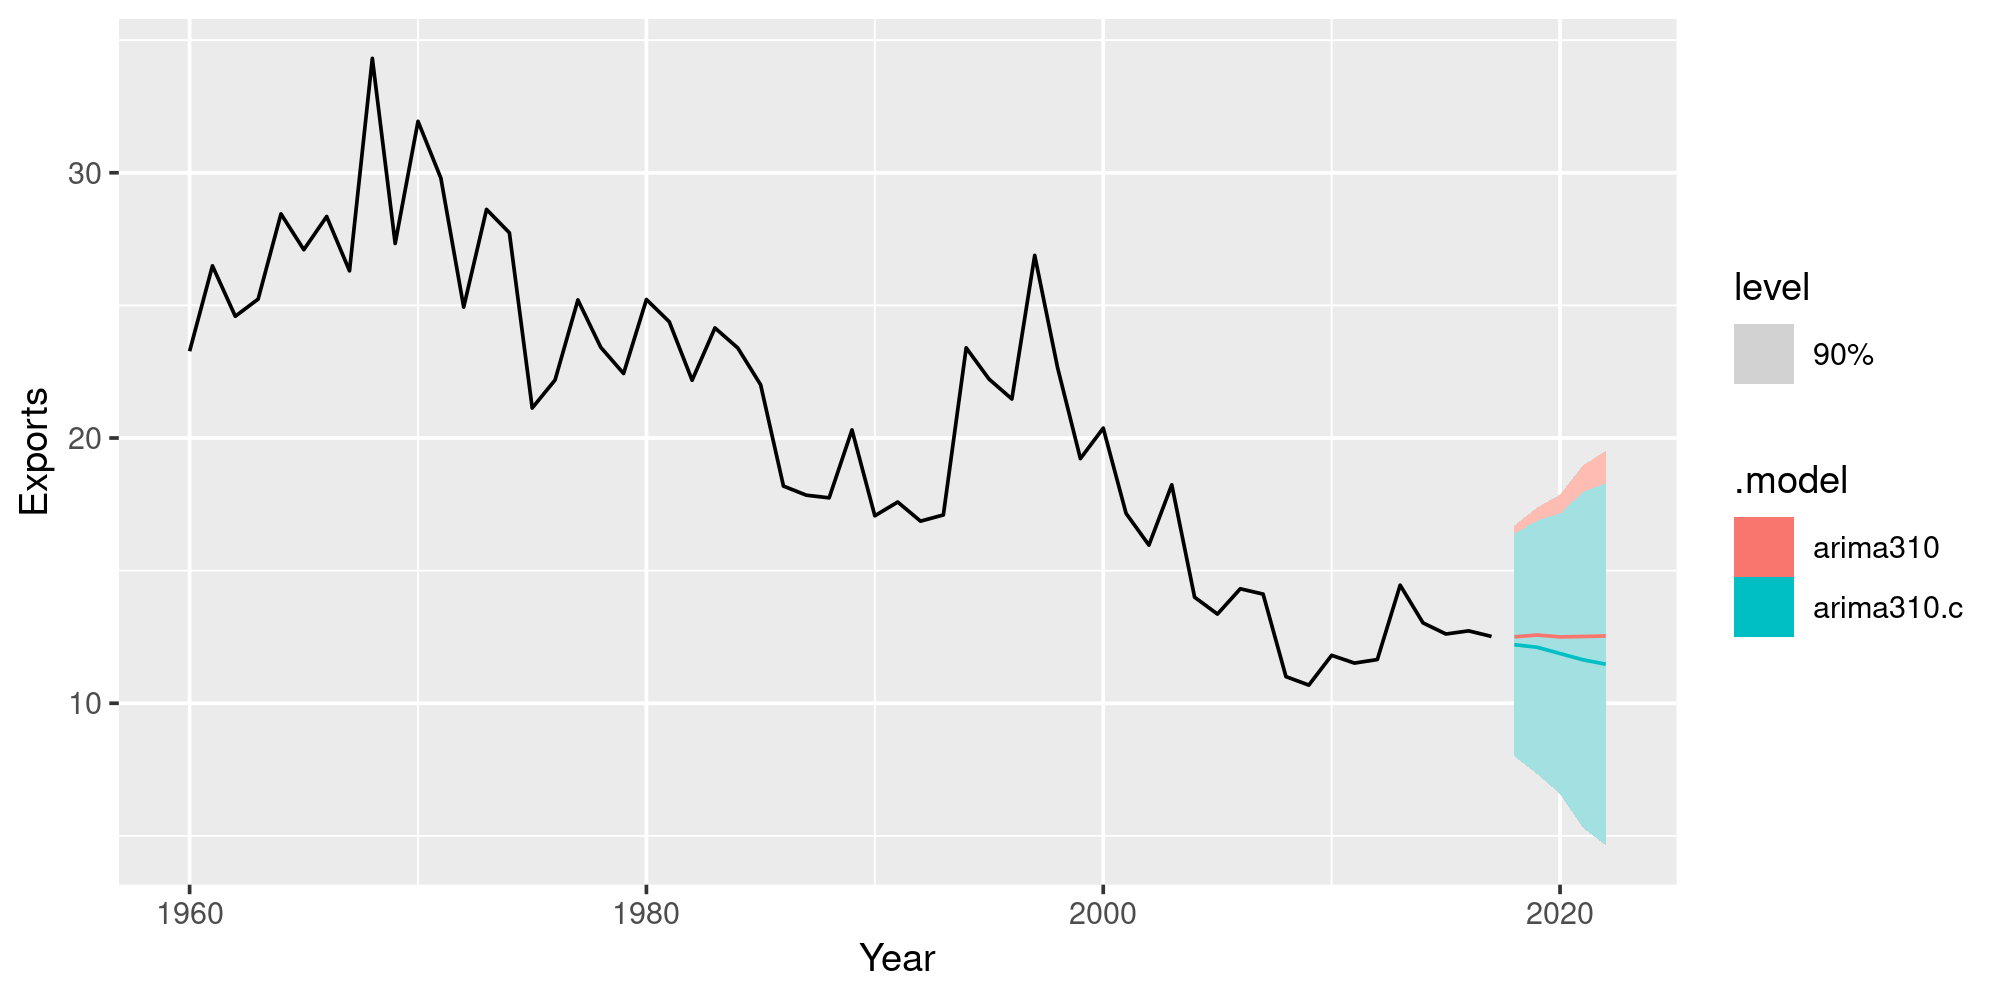

In [8]:
global_economy |>
  filter(Code == "CAF") |>
  model(arima310 = ARIMA(Exports ~ pdq(3,1,0)),
        arima310.c = ARIMA(Exports ~ 1 + pdq(3,1,0))
       ) |>
  forecast(h=5) |>
  autoplot(global_economy, level=90)

## Forecasting with ARIMA models

Point forecasts can be calculated using the following three steps.

1. Expand the ARIMA equation so that $y_t$ is on the left hand side and all other terms are on the right.
2. Rewrite the equation by replacing $t$ with $T+h$.
3. On the right hand side of the equation, replace future observations with their forecasts, future errors with zero, and past errors with the corresponding residuals.

## Forecasting with ARIMA models (example)

ARIMA(3,1,1) model:
$$
(1-\hat{\phi}_1B -\hat{\phi}_2B^2-\hat{\phi}_3B^3)(1-B) y_t = (1+\hat{\theta}_1B)\varepsilon_{t}.
$$


## Forecasting with ARIMA models (example)

Expand the left hand side to obtain 
$$
\left[1-(1+\hat{\phi}_1)B +(\hat{\phi}_1-\hat{\phi}_2)B^2 + (\hat{\phi}_2-\hat{\phi}_3)B^3 +\hat{\phi}_3B^4\right] y_t = (1+\hat{\theta}_1B)\varepsilon_{t},
$$

Applying the backshift operator gives 
$$
y_t - (1+\hat{\phi}_1)y_{t-1} +(\hat{\phi}_1-\hat{\phi}_2)y_{t-2} + (\hat{\phi}_2-\hat{\phi}_3)y_{t-3} +\hat{\phi}_3y_{t-4} = \varepsilon_t+\hat{\theta}_1\varepsilon_{t-1}.
$$

 Finally, we move all terms other than $y_t$ to the right hand side
 \begin{equation}
  y_t = (1+\hat{\phi}_1)y_{t-1} -(\hat{\phi}_1-\hat{\phi}_2)y_{t-2} - (\hat{\phi}_2-\hat{\phi}_3)y_{t-3} -\hat{\phi}_3y_{t-4} + \varepsilon_t+\hat{\theta}_1\varepsilon_{t-1}.
\end{equation}

## Forecasting with ARIMA models (example)

Replace $t$ with $T+1$:
$$
y_{T+1} = (1+\hat{\phi}_1)y_{T} -(\hat{\phi}_1-\hat{\phi}_2)y_{T-1} - (\hat{\phi}_2-\hat{\phi}_3)y_{T-2} -\hat{\phi}_3y_{T-3} + \varepsilon_{T+1}+\hat{\theta}_1\varepsilon_{T}.
$$

Replace future errors with 0, and past errors with residuals:
$$
\hat{y}_{T+1|T} = (1+\hat{\phi}_1)y_{T} -(\hat{\phi}_1-\hat{\phi}_2)y_{T-1} - (\hat{\phi}_2-\hat{\phi}_3)y_{T-2} -\hat{\phi}_3y_{T-3} + \hat{\theta}_1e_{T}.
$$

A forecast of $y_{T+2}$ is obtained by replacing $t$ with $T+2$:
$$
\hat{y}_{T+2|T} = (1+\hat{\phi}_1)\hat{y}_{T+1|T} -(\hat{\phi}_1-\hat{\phi}_2)y_{T} - (\hat{\phi}_2-\hat{\phi}_3)y_{T-1} -\hat{\phi}_3y_{T-2}.
$$

## Prediction intervals

The calculation of ARIMA prediction intervals is more difficult, and beyond the scope of this course.

The first prediction interval is easy to calculate. If $\hat{\sigma}$ is the standard deviation of the residuals, then a 95% prediction interval is given by
$$
    \hat{y}_{T+1 \mid T} \pm 1.96 \cdot \hat{\sigma}.
$$

This result is true for all ARIMA models regardless of their parameters and orders.

In general, prediction intervals from ARIMA models increase as the forecast horizon increases. 

## Bootstrapped predictions intervals

If the residuals are uncorrelated but not normally distributed, then bootstrapped intervals can be obtained instead, as discussed earlier in the course. 

This is easily achieved by simply adding `bootstrap=TRUE` in the `forecast()` function.

## Why prediction intervals are often too short

As with most prediction interval calculations, ARIMA-based intervals tend to be too narrow. 

This occurs because only the variation in the errors has been accounted for. 

There is also variation in the parameter estimates, and in the model order, that has not been included in the calculation.

In addition, the calculation assumes that the historical patterns that have been modelled will continue into the forecast period.

## Seasonal ARIMA models

A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA models we have seen so far.


<p align="center">
  <img src="img/sARIMA.png" alt="Seasonal ARIMA" width="400"/>
</p>

where $m$ is the seasonal period.

We use uppercase notation for the seasonal parts of the model, and lowercase notation for the non-seasonal parts of the model.

The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period.

The additional seasonal terms are simply multiplied by the non-seasonal terms.

## Seasonal ARIMA model (example)

$\text{ARIMA}(1,1,1)(1,1,1)_4$ model (without a constant) is for quarterly data ($m=4$),
$$
(1 - \phi_{1}B)~(1 - \Phi_{1}B^{4}) (1 - B) (1 - B^{4})y_{t} =
  (1 + \theta_{1}B)~ (1 + \Theta_{1}B^{4})\varepsilon_{t}.
$$

## Example: Monthly US leisure and hospitality employment

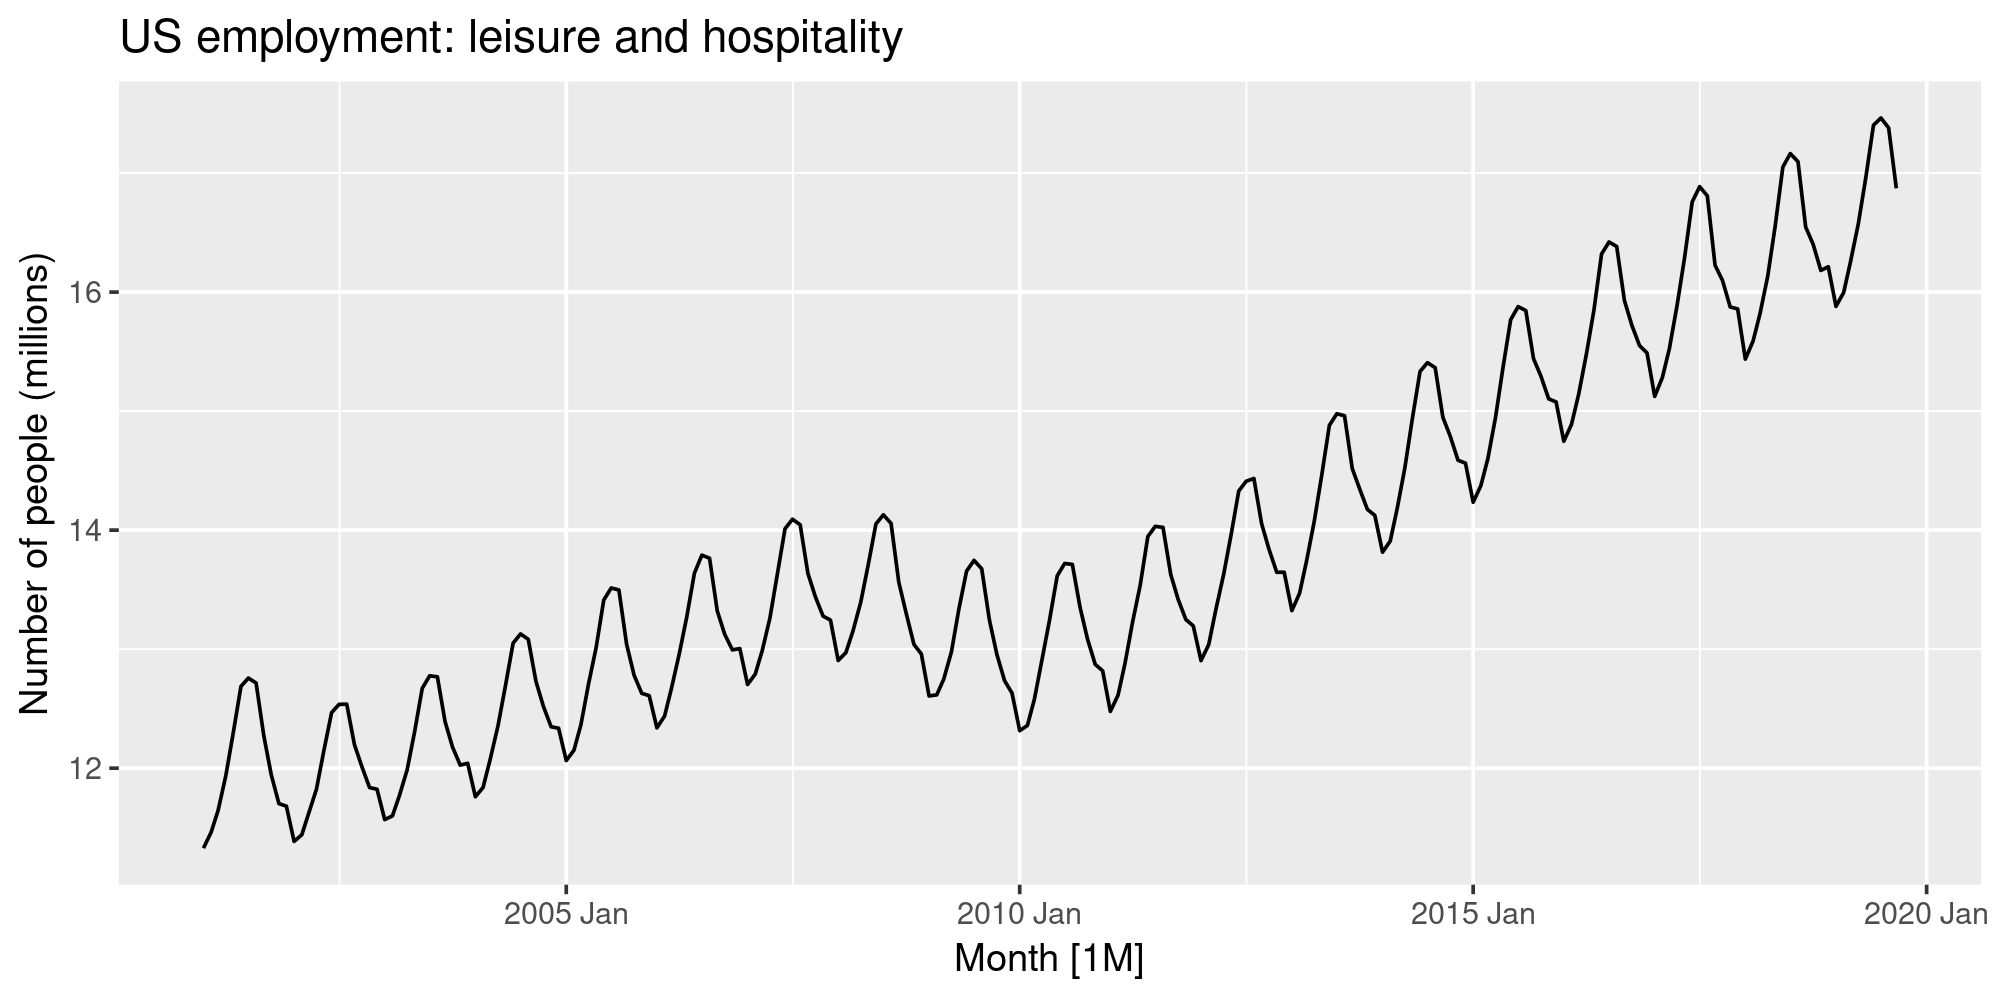

In [9]:
leisure <- us_employment |>
  filter(Title == "Leisure and Hospitality", year(Month) > 2000) |>
  mutate(Employed = Employed/1000) |>
  select(Month, Employed)

autoplot(leisure, Employed) +
  labs(title = "US employment: leisure and hospitality",
       y="Number of people (millions)")

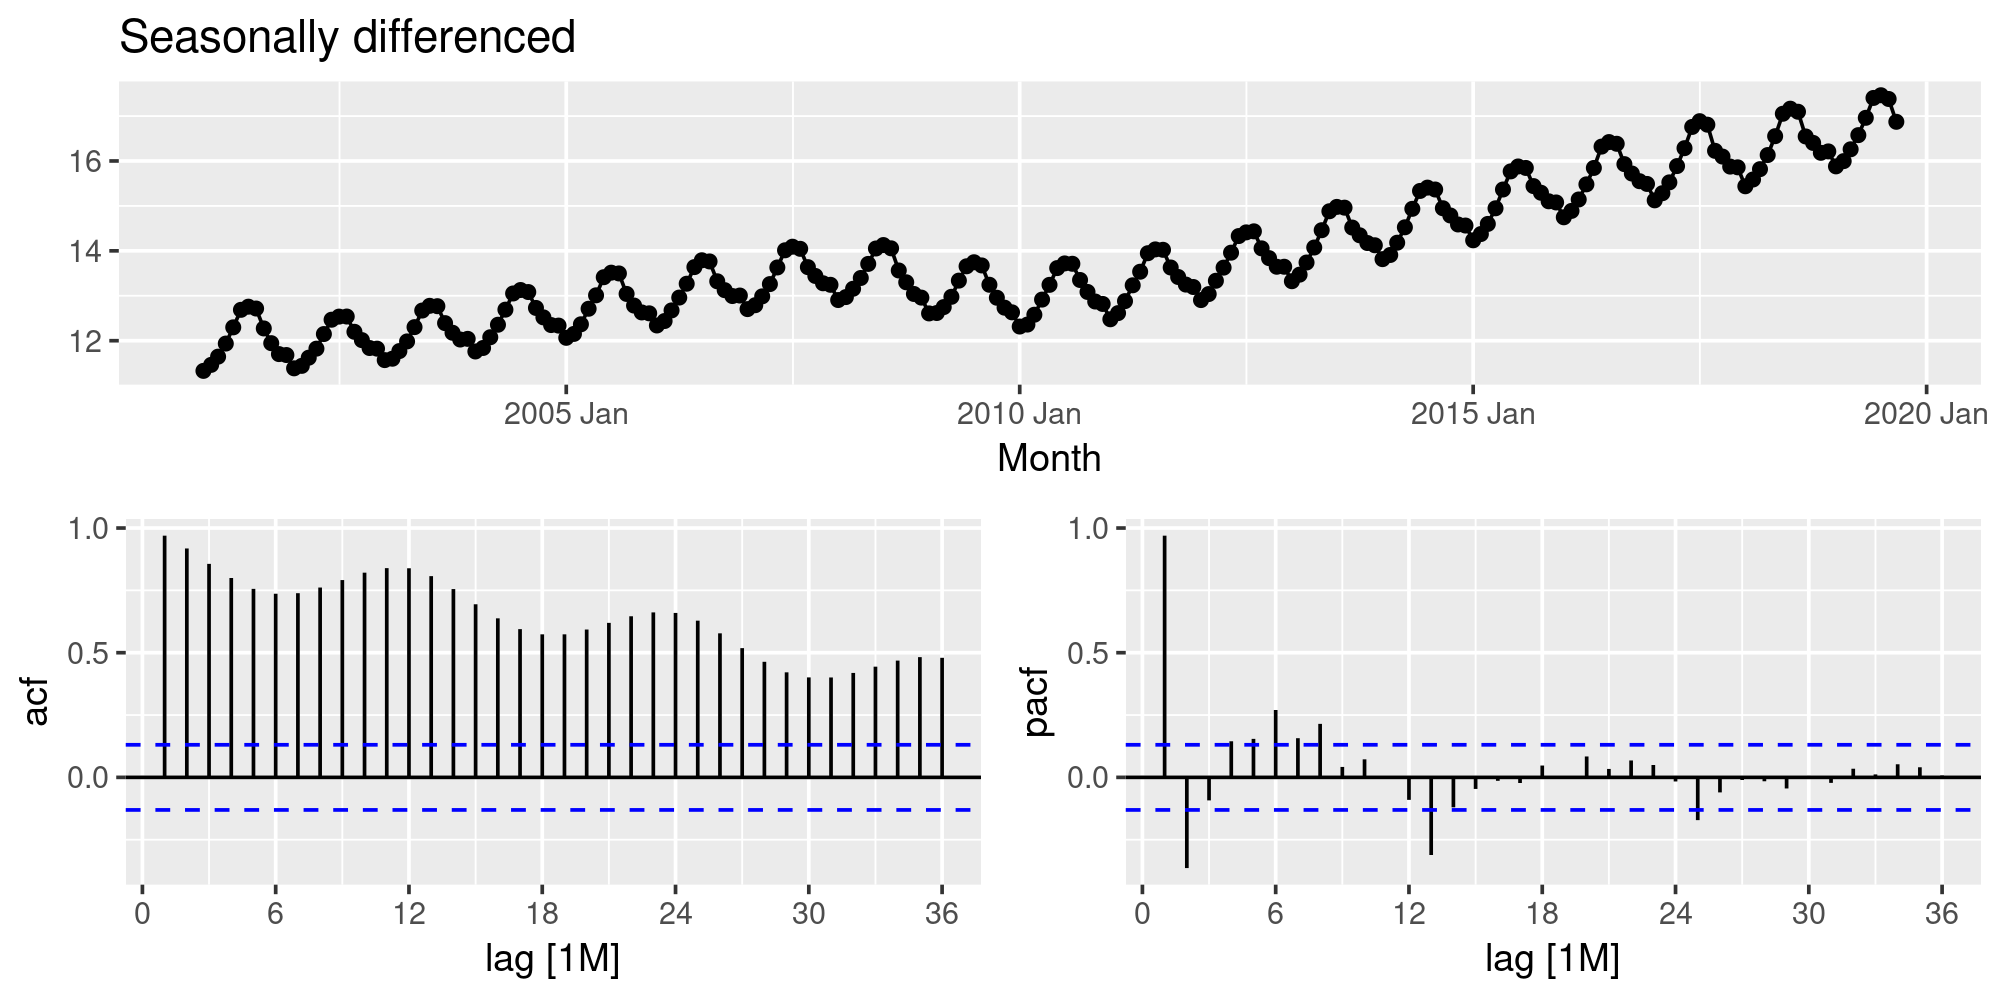

In [10]:
leisure |>
  gg_tsdisplay(Employed #|> difference(12) #|> difference()
               , plot_type='partial', lag=36) +
  labs(title="Seasonally differenced", y="")

In [11]:
fit <- leisure |>
  model(arima.step = ARIMA(Employed),
        arima.search = ARIMA(Employed, stepwise = FALSE))

In [12]:
fit |> pivot_longer(everything(), names_to = "Model name", values_to = "Orders")

Model name,Orders
<chr>,<model>
arima.step,"<ARIMA(1,1,1)(2,1,1)[12]>"
arima.search,"<ARIMA(1,1,1)(2,1,1)[12]>"


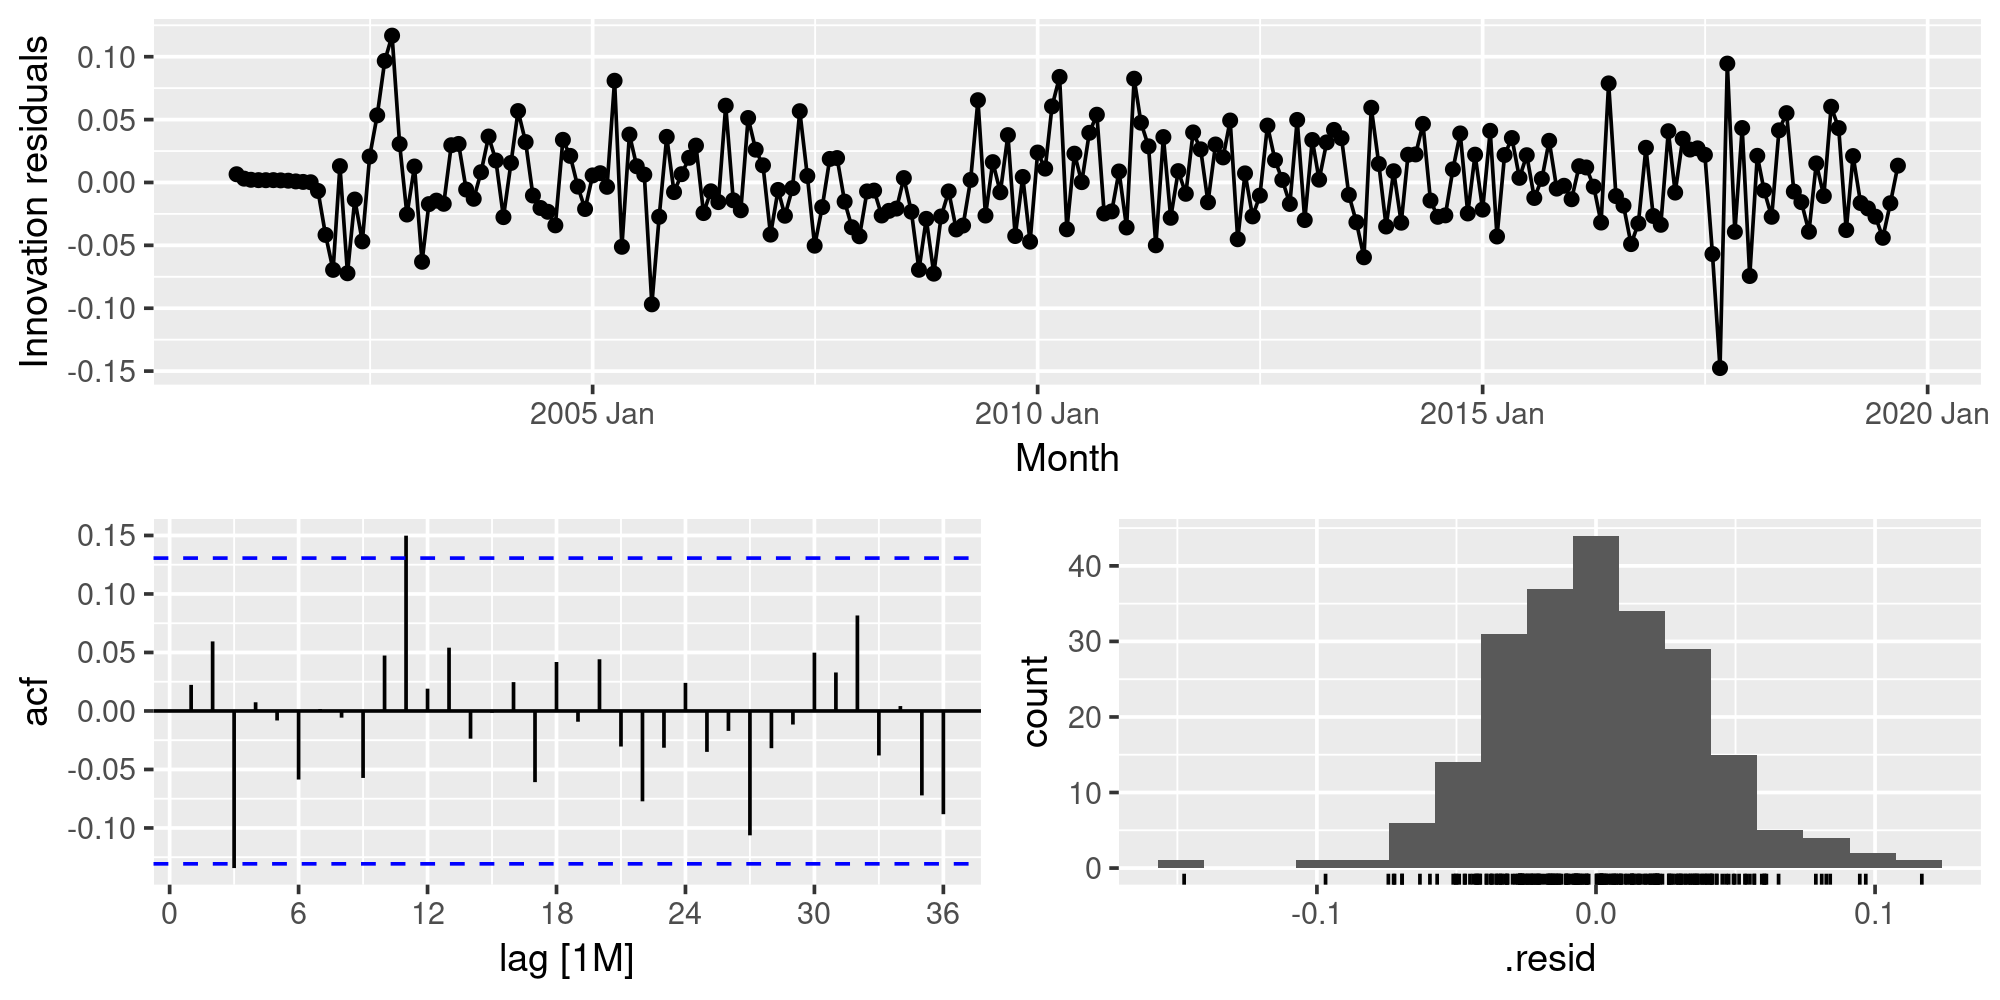

In [13]:
fit |> select(arima.step) |> gg_tsresiduals(lag=36)

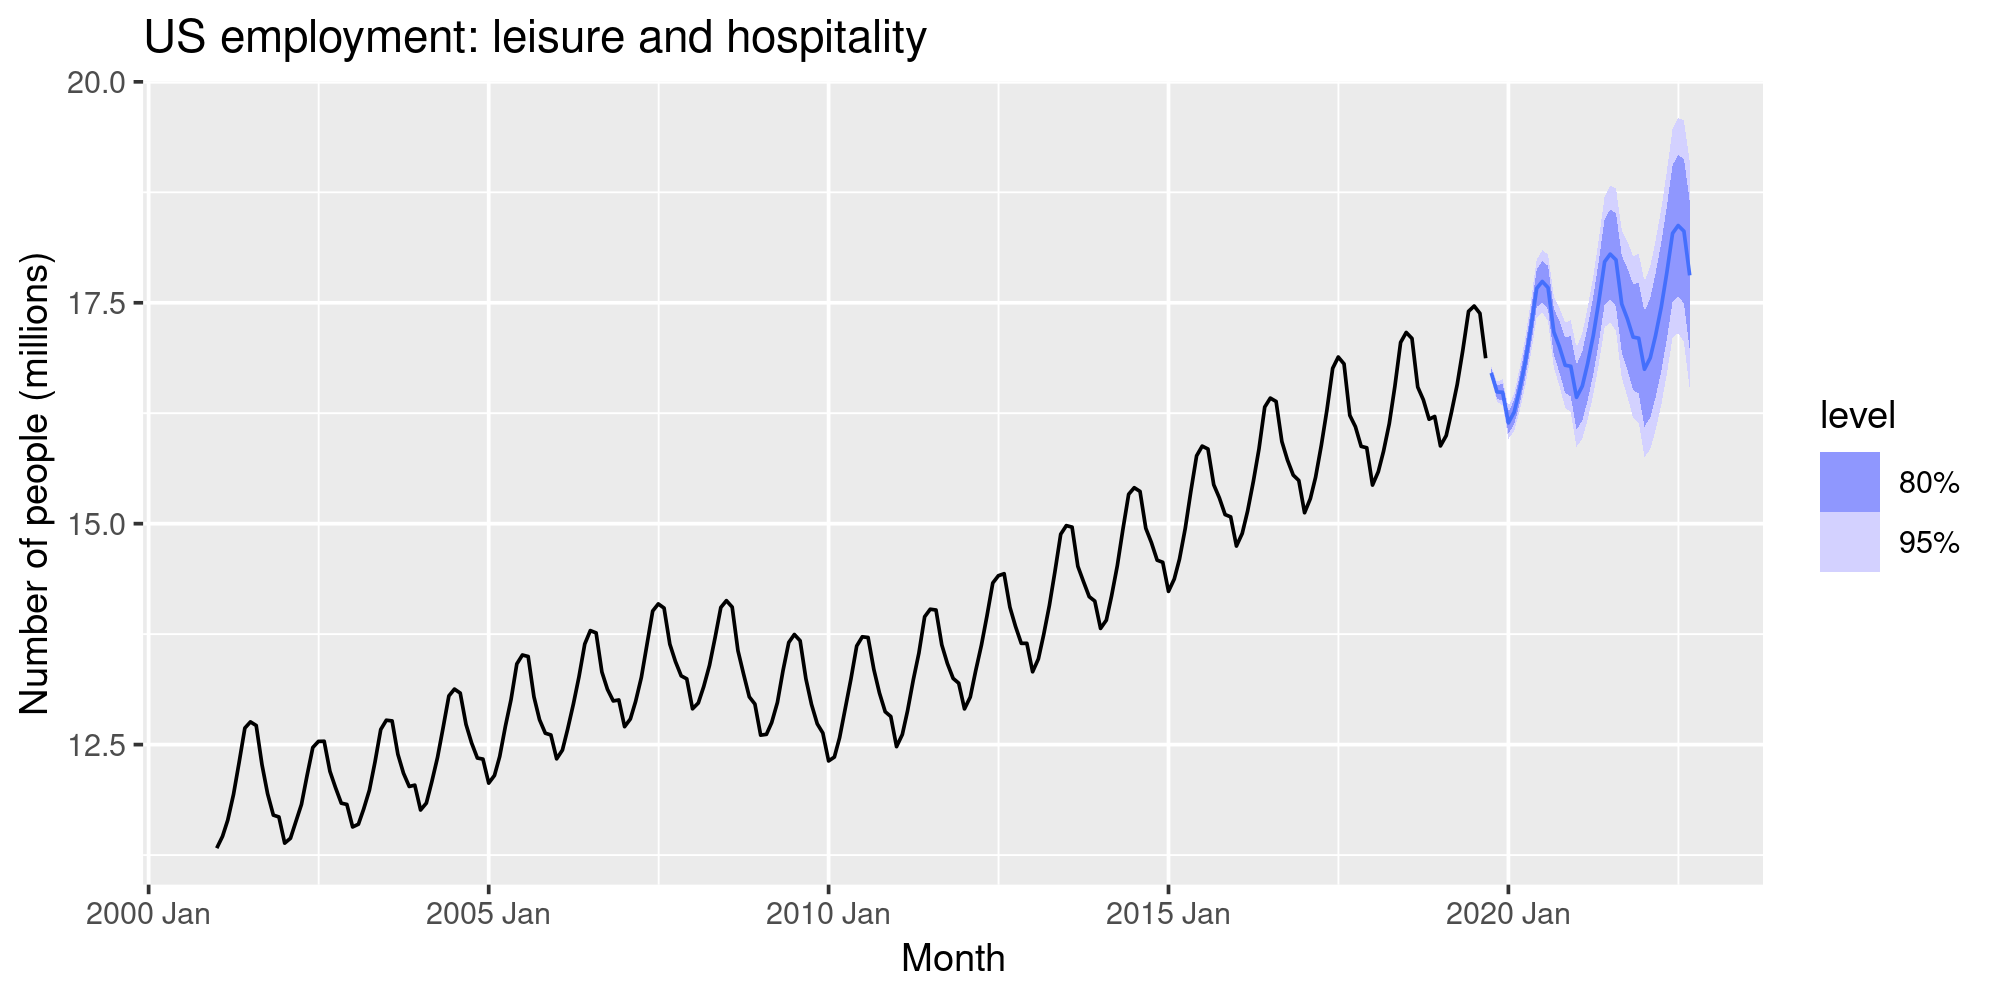

In [14]:
fit |>
    forecast(h=36) |>
    filter(.model=='arima.search') |>
    autoplot(leisure) +
          labs(title = "US employment: leisure and hospitality",
               y="Number of people (millions)")

## ARIMA vs ETS

- While linear exponential smoothing models are all special cases of ARIMA models, the non-linear exponential smoothing models have no equivalent ARIMA counterparts. 

- On the other hand, there are also many ARIMA models that have no exponential smoothing counterparts.

- In particular, all ETS models are non-stationary, while some ARIMA models are stationary.

- We can use time series cross-validation to compare ARIMA and ETS models. 

## Example (non-seasonal)

In [15]:
caf_economy <- global_economy |>
  filter(Code == "CAF") |>
  select(Year, Exports)

caf_economy |>
    stretch_tsibble(.init = 10) |>
    model(ETS(Exports), ARIMA(Exports)) |>
    forecast(h = 1) |>
    accuracy(caf_economy) |>
    select(.model, RMSE:MAPE)

Warning message:
“The future dataset is incomplete, incomplete out-of-sample data will be treated as missing. 
1 observation is missing at 2018”


.model,RMSE,MAE,MPE,MAPE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ARIMA(Exports),3.061456,2.370463,-6.143472,12.150809
ETS(Exports),2.562081,1.882114,-4.514561,9.907227


In this case the ETS model has higher accuracy on the cross-validated performance measures.

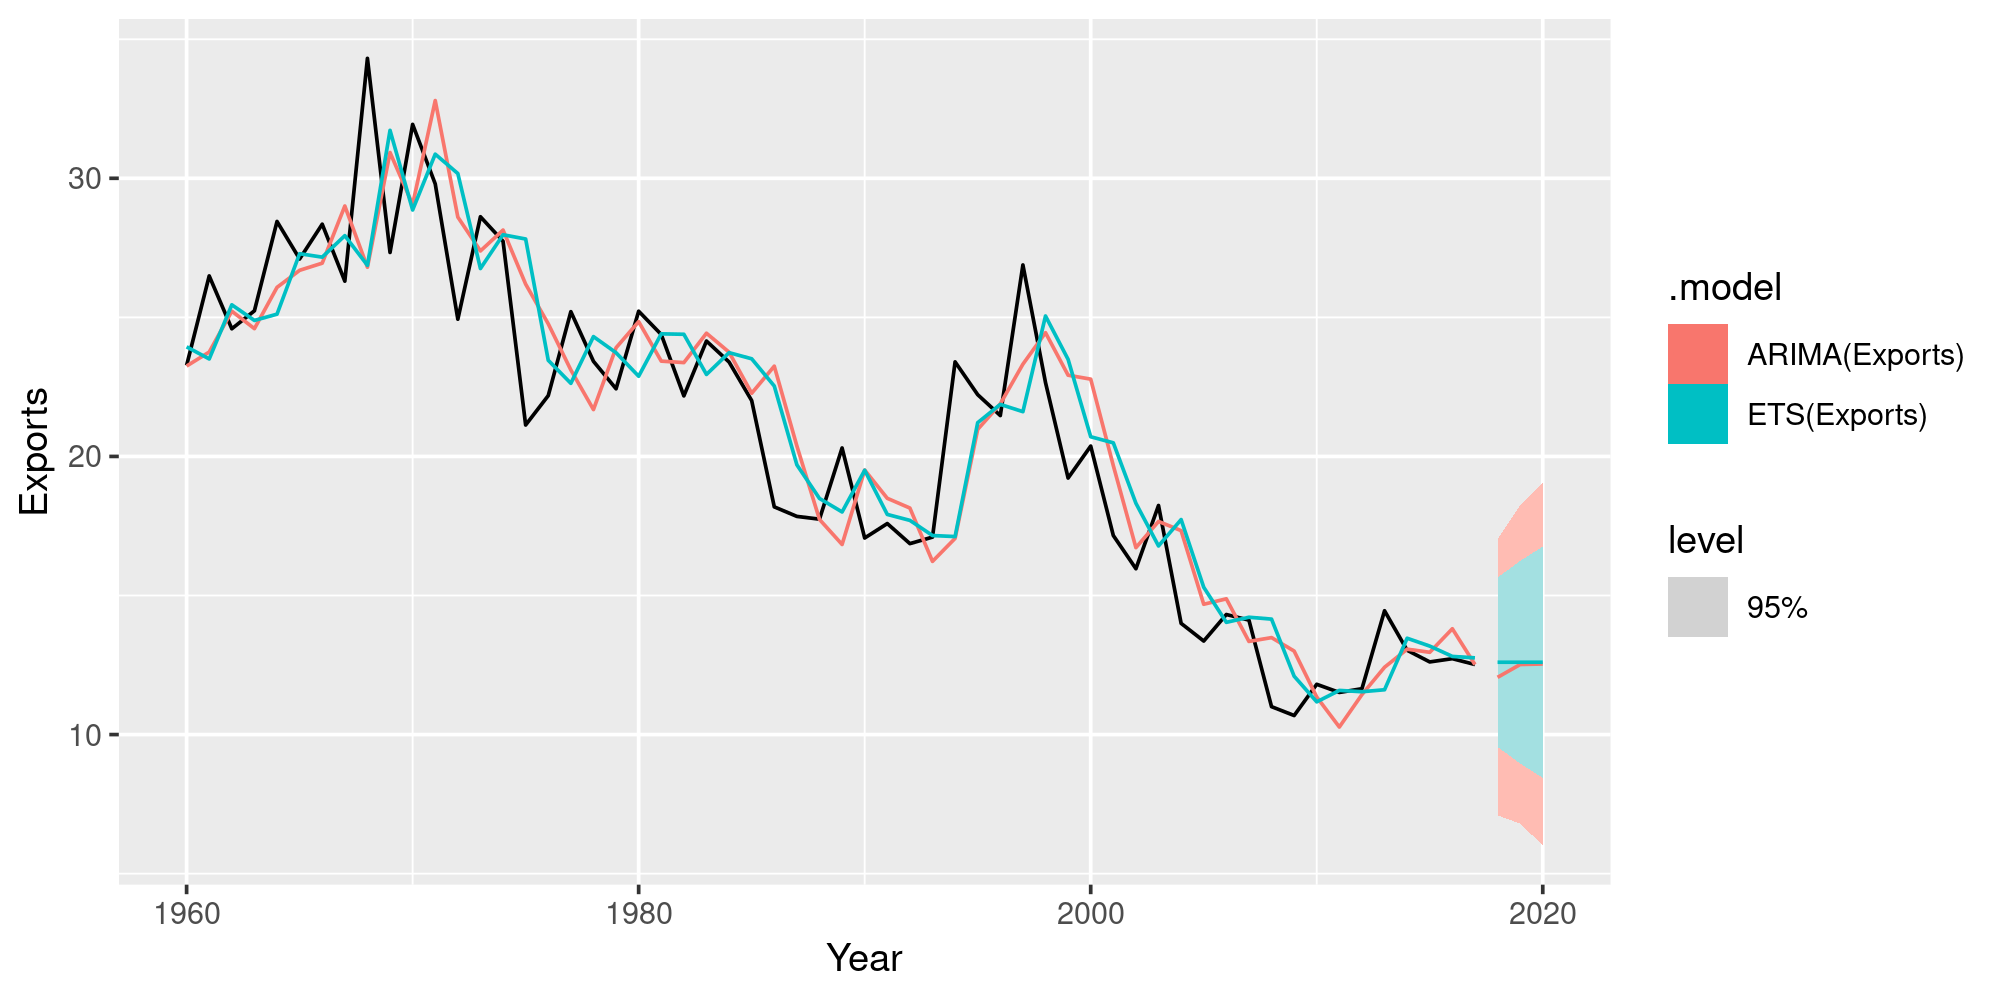

In [16]:
fit <- caf_economy |>
    model(ETS(Exports), ARIMA(Exports))
fit |>
    forecast(h=3) |>
    autoplot(caf_economy, level=95) +
    geom_line(aes(y = .fitted, color=.model), data=augment(fit))

In [17]:
fit |> augment()

.model,Year,Exports,.fitted,.resid,.innov
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ETS(Exports),1960,23.27272,23.94052,-0.6677933,-0.02789385
ETS(Exports),1961,26.49007,23.50505,2.9850144,0.12699459
⋮,⋮,⋮,⋮,⋮,⋮
ARIMA(Exports),2016,12.72904,13.80415,-1.075102691,-1.075102691
ARIMA(Exports),2017,12.51809,12.51608,0.002011289,0.002011289


## Example (seasonal)

In [18]:
leisure_train <- leisure |> filter_index(. ~ "2016 Dec")
leisure_test <- leisure |> filter_index("2017 Jan" ~ .)

leisure_train |>
    model(ETS(Employed), ARIMA(Employed)) |>
    forecast(leisure_test) |>
    accuracy(leisure_test)

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARIMA(Employed),Test,0.04713227,0.0773500,0.06365039,0.2789962,0.3829249,NaN,NaN,0.5165547
ETS(Employed),Test,0.07419102,0.1091653,0.08635562,0.4396975,0.5183274,NaN,NaN,0.5775237


In this case, the ARIMA model does better.

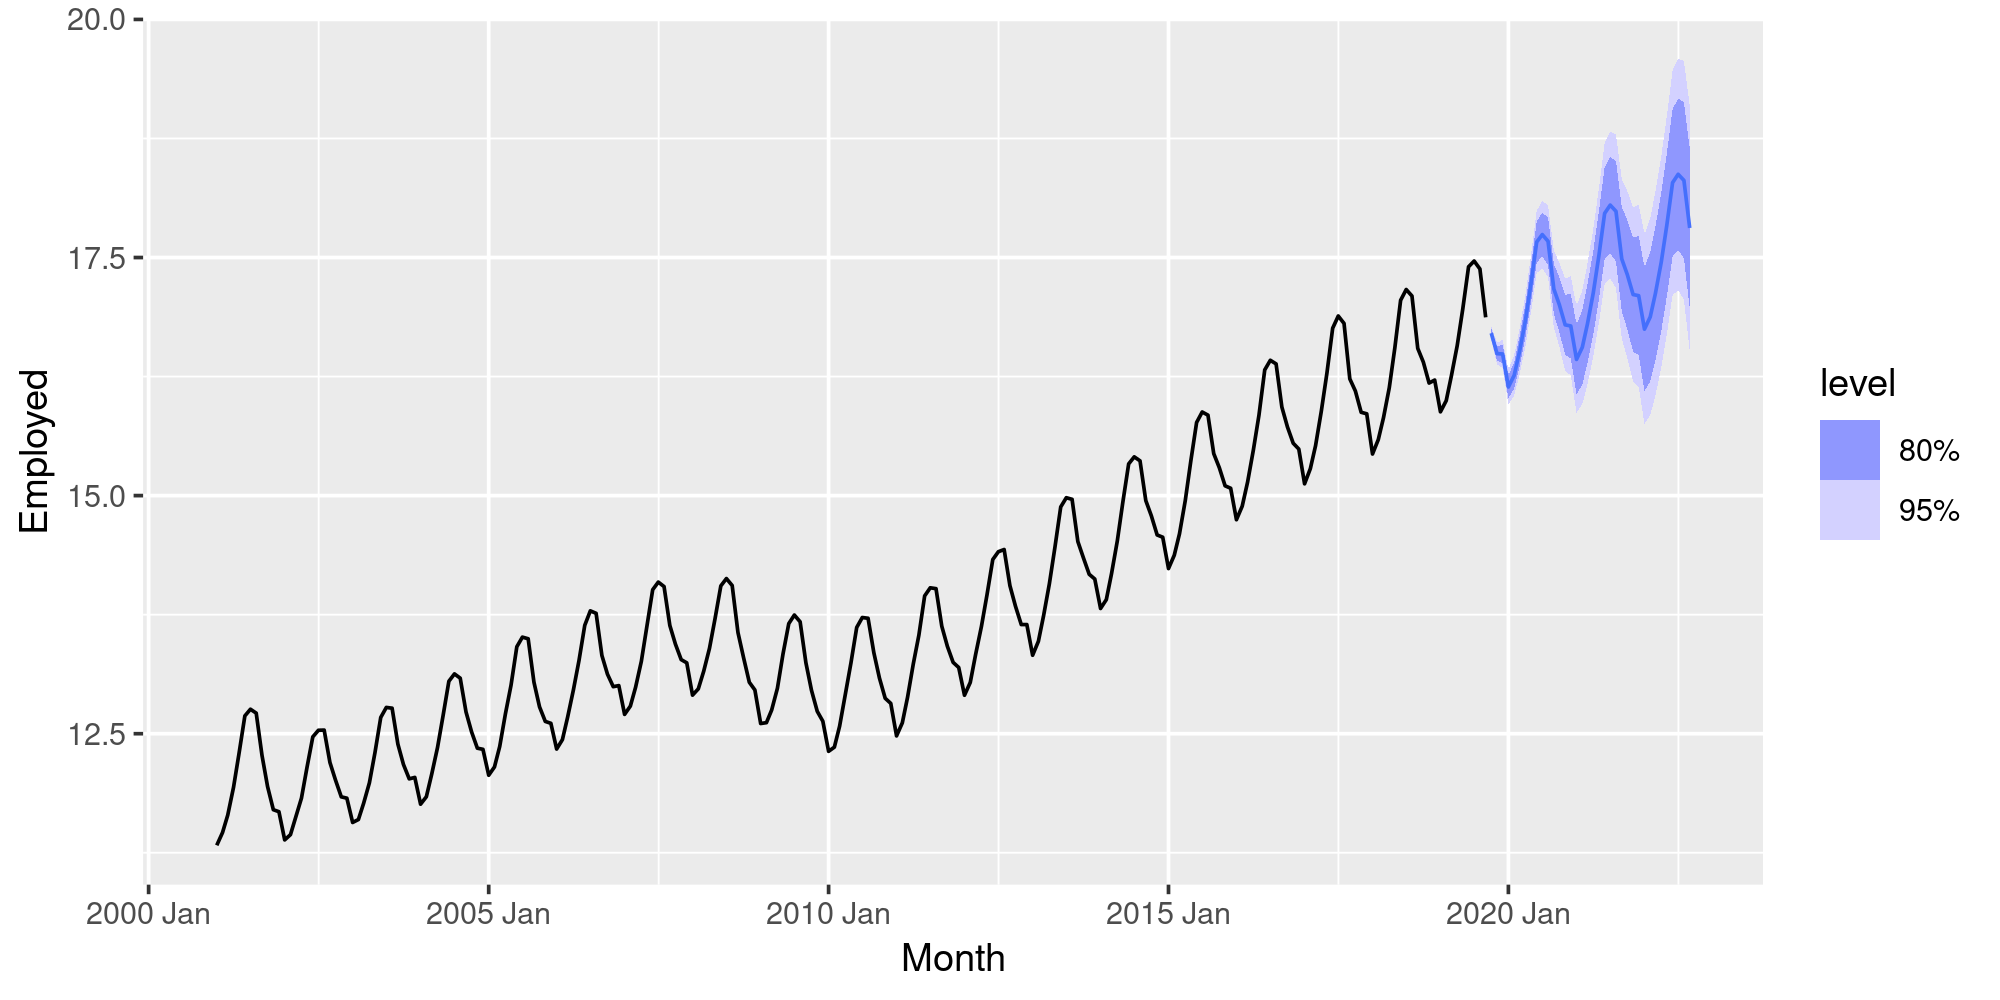

In [19]:
leisure |>
    model(ARIMA(Employed)) |>
    forecast(h="3 years") |>
    autoplot(leisure)

## Next time

 - Dynamic regression models